# Phylogenetic signal of average of optimal growth temperature

In [1]:
library(ape)
library(phytools)
library(caper)
library(geiger)

Loading required package: maps

code for methods in class “Rcpp_Fitch” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_Fitch” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Loading required package: MASS

Loading required package: mvtnorm



Load data

In [2]:
data <- read.table("../phylogeny/place/fine_all_temperature.tsv", header=TRUE, sep="\t", quote="")
head(data, 3)

,taxid,length,width,volume,surface,shape,species,genus,family,order,⋯,coding,rrnas,MILC,B,MCB,ENC,ENCprime,SCUO,hash,topt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,taxid14,10.00000,0.4898979,1.85417440,15.390598,rod-shaped,Dictyoglomus thermophilum,Dictyoglomus,Dictyoglomaceae,Dictyoglomales,⋯,93.77725,2,0.058817141,-0.192631758,-0.05707928,0.0218529,-1.104863e-02,-0.2228213,1.50,78
2,taxid23,1.50000,0.7000000,0.48747046,3.298672,rod-shaped,Shewanella colwelliana,Shewanella,Shewanellaceae,Alteromonadales,⋯,87.38314,0,0.135029019,-0.002838678,0.08282373,0.2153492,-3.105027e-02,-1.1902120,1.37,25
3,taxid104,1.03923,0.3464102,0.08706237,1.130973,ring-shaped,Cyclobacterium marinum,Cyclobacterium,Cyclobacteriaceae,Cytophagales,⋯,87.12132,3,0.009948511,-0.257339233,-0.15164623,0.1002689,-6.795228e-05,-0.4924868,1.75,25


In [3]:
nrow(data)

[1] 3431

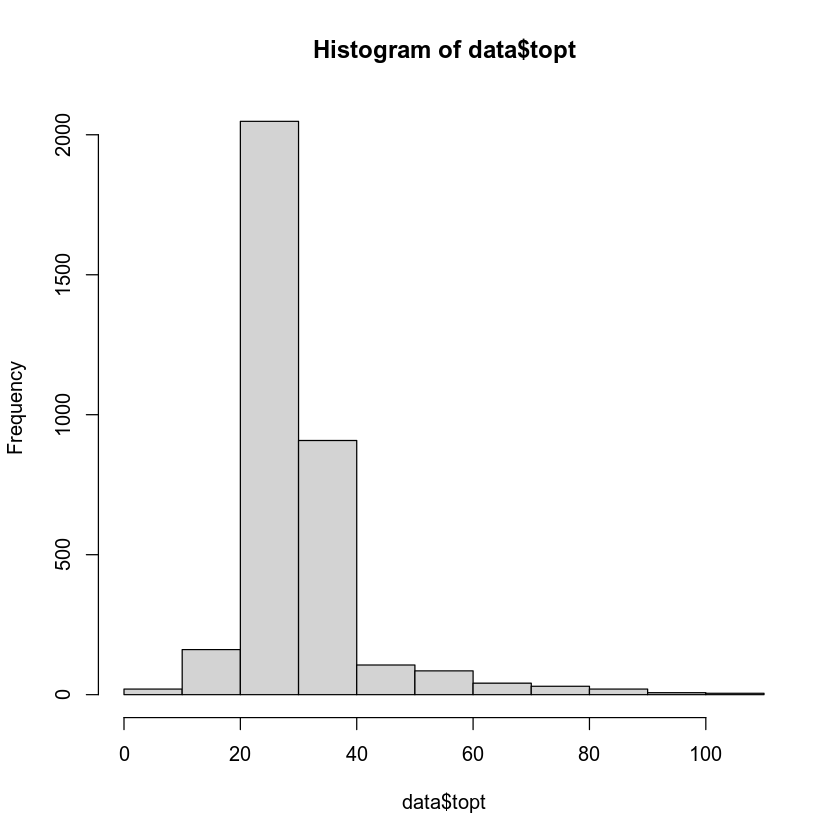

In [4]:
hist(data$topt)

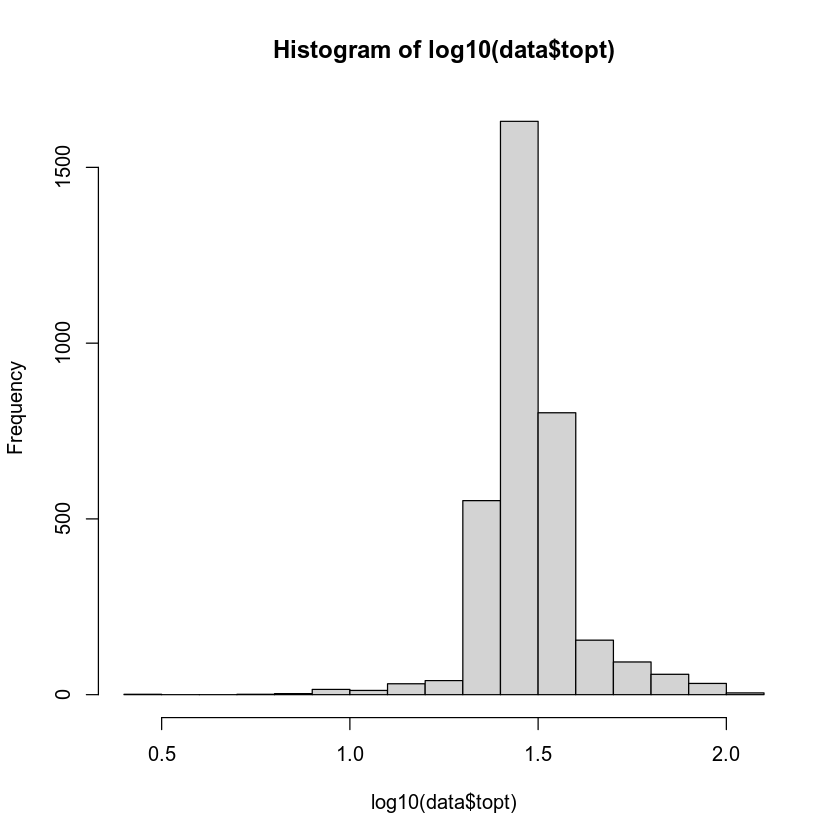

In [5]:
hist(log10(data$topt))

Load tree

In [6]:
tree <- read.tree("../phylogeny/place/fine_all_temperature.nwk")
tree


Phylogenetic tree with 3431 tips and 1288 internal nodes.

Tip labels:
  taxid71518, taxid83984, taxid2193, taxid83985, taxid71152, taxid2203, ...
Node labels:
  N1, N5, N18, N51, N79, N119, ...

Rooted; includes branch lengths.

### Pagel's $\lambda, \sigma^2$ - geiger 

In [7]:
# Binarize tree - required for geiger package
tree2 <- multi2di(tree)

In [8]:
# Dataframe to save outputs
df_geiger <- data.frame(matrix(ncol=6, nrow=0))
colnames(df_geiger) <- c('lambda', 'pval0', 'pval1', 'sigsq',
                 'sigsq_unb', 'lnL')
df_geiger

lambda,pval0,pval1,sigsq,sigsq_unb,lnL
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>


In [9]:
lambda_sigsq <- function(tree, x){
    # Fit model
    lambda2 <- fitContinuous(tree, x, model="lambda")
    # Reescale tree such that lambda = 0, i.e. star phylogeny
    t0 <- rescale(tree, 'lambda', 0)
    # Fit tree and trait to a BM model of evolution
    lambda_L0 <- fitContinuous(t0, x, model = 'BM')
    # Likelihood ratio test
    LLR0 <- -2 * (lambda_L0$opt$lnL - lambda2$opt$lnL)
    # Get a p-value from a chi-sq distribution
    pval0 <- pchisq(LLR0, df = 1, lower.tail = FALSE)
    
    # Test if lambda != 1
    lambda_L1 <- fitContinuous(tree, x, model = 'BM')
    # Likelihood ratio test
    LLR1 <- -2 * (lambda_L1$opt$lnL - lambda2$opt$lnL)
    # Get a p-value
    pval1 <- pchisq(LLR1, df = 1, lower.tail = FALSE)
    # sigsq
    sigsq <- lambda2$opt$sigsq
    # Get the unbiased estimator of sigsq
    sigsq_unb <- lambda2$opt$sigsq * length(tree$tip.label)/(length(tree$tip.label)-1)
    # Get the likelihood
    lnL <- lambda2$opt$lnL
    
    return(list(lambda = lambda2$opt$lambda, pval0 = pval0, 
                pval1 = pval1, sigsq = sigsq, sigsq_unb = sigsq_unb,
               lnL = lnL))
}

In [10]:
datum <- setNames(data$topt, data$taxid)

In [11]:
l_sq <- lambda_sigsq(tree2, datum)
l_sq

$lambda
[1] 0.9857212

$pval0
[1] 0

$pval1
[1] 0.0002240962

$sigsq
[1] 171.076

$sigsq_unb
[1] 171.1259

$lnL
[1] -11051.71

In [12]:
# datum <- setNames(log10(data$topt), data$taxid)

In [13]:
# l_sq <- lambda_sigsq(tree2, datum)
# l_sq

In [14]:
df_geiger[nrow(df_geiger) + 1,] <- c(l_sq$lambda, l_sq$pval0, l_sq$pval1, l_sq$sigsq,
                                    l_sq$sigsq_unb, l_sq$lnL)
rownames(df_geiger)[nrow(df_geiger)] <- "topt"
df_geiger

,lambda,pval0,pval1,sigsq,sigsq_unb,lnL
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
topt,0.9857212,0,0.0002240962,171.076,171.1259,-11051.71


In [15]:
# Save x and y positions for likelihood calculation
lambda2 <- fitContinuous(tree2, datum, model = 'lambda')
# For lambda
xpos1 <- seq(0, 1, length.out = 50)
# For sigmasq
xpos2 <- seq(0, 3, length.out = 50)
ypos <- c()
for (i in 1:length(xpos1)){
    ypos[i] <- lambda2$lik(c(xpos1[i], xpos2[i]))
}

In [16]:
write.table(data.frame(x1 = xpos1, x2 = xpos2, y = ypos), "physig/topt.lambda-sigsq.plot", 
            sep="\t", col.names=FALSE, row.names=FALSE)

In [17]:
write.table(df_geiger, "physig/lambda_topt-sigsq.tsv", sep="\t", quote=FALSE)

### Blomberg's K

In [18]:
df <- data.frame(matrix(ncol=2, nrow=0))
colnames(df) <- c("K", "P")

In [19]:
datum <- setNames(data$topt, data$taxid)

In [20]:
set.seed(42)
K <- phylosig(tree, datum, method="K", test=TRUE)
K


Phylogenetic signal K : 3.89783 
P-value (based on 1000 randomizations) : 0.001 


In [21]:
df[nrow(df) + 1,] <- c(K$K, K$P)
rownames(df)[nrow(df)] <- "topt"

In [22]:
write.table(df, "physig/topt_K.tsv", sep="\t", quote=FALSE)

In [23]:
writeLines(capture.output(K), "physig/topt.K")

In [24]:
write.table(K$sim.K, "physig/topt.K.plot", col.names=FALSE, row.names=FALSE)